# Color classify

In [54]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # print('bin_spatial size:',len(features))
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector 
    # print('color_hist size:',len(hist_features))
    return hist_features


# Read in car and non-car images

#for filename in glob.iglob('./non-vehicles/**/*.png', recursive=True):
#    pass #print(filename)

notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)
print('notcars:',len(notcars))

cars = glob.glob('./vehicles/**/*.png', recursive=True)
print('cars:',len(cars))


notcars: 8968
cars: 8792


# HOG classify

In [55]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        # print('get_hog_features size:',len(features))
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def images_from_file(file, cspace):
    # Iterate through the list of images

    # Read in each one by one
    image = mpimg.imread(file)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    return feature_image



def extract_features(img, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins=32):    
    # Apply bin_spatial() to get spatial color features
    spatial_size=(32, 32)
    feature_image = img

    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_range=(0, 256)

    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_feat = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True)
            hog_features.append(hog_feat)
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features = np.ravel(hog_features)
        
    feature_vec = np.concatenate((spatial_features, hist_features,hog_features))
    return feature_vec
    
def extract_features_from_paths(img_file_paths, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in img_file_paths:
        feature_image = images_from_file(file, cspace)
        feature_vec = extract_features(feature_image, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, hist_bins=hist_bins)
            
        # Append the new feature vector to the features list
        features.append(feature_vec)
    # Return list of feature vectors
    return features


In [56]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


def train_and_evaluate(cars, notcars, colorspace, orient, pix_per_cell, cell_per_block, hog_channel, C, hist_bins):

    t=time.time()
    car_features = extract_features_from_paths(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
    notcar_features = extract_features_from_paths(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    # print('len(car_features)',len(car_features))
    # print('car_features[0].shape',car_features[0].shape)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print('X.shape',X.shape)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    #print('min X', np.min(X), 'max X', np.max(X))
    #print('mean X', np.mean(X), 'std X', np.std(X))

    # Split up data into randomized training and test sets
    rand_state = 42 #np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    # svc = SVC(C=C)
    # svc = DecisionTreeClassifier()
    svc = LinearSVC(C=C)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    score = round(svc.score(X_train, y_train), 4)
    print('Train Accuracy of SVC = ', score)
    score = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', score)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts:      ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return score, svc, X_scaler

In [49]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 100 #len(cars)
selected_samples = np.random.choice(min(len(cars),len(notcars)),sample_size)

cars_sample = [cars[i] for i in selected_samples]
print('sample_size: ',sample_size, 'len(cars_sample): ',len(cars_sample))
notcars_sample = [notcars[i] for i in selected_samples]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orients = [9]
pix_per_cells = [4,16]
cell_per_blocks = [2]
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
C_list = [1]
hist_bins_list = [16,20,]

param_gen=[(orient,pix_per_cell, cell_per_block, C, hist_bins) for orient in orients for pix_per_cell in pix_per_cells
             for cell_per_block in cell_per_blocks for C in C_list for hist_bins in hist_bins_list]

res = dict()
res['score'] = list()
res['params'] = list()
res['model'] = list() 
res['X_scaler'] = list()

# Grid search for best hyperparameters
for (orient,pix_per_cell, cell_per_block, C, hist_bins) in param_gen:
    try:
        print('orient:', orient, ' pix_per_cell:',pix_per_cell, ' cell_per_block:', cell_per_block,
              'C:', C, ' hist_bins:', hist_bins)
        score, svc, X_scaler = train_and_evaluate(cars_sample, notcars_sample, colorspace, orient, pix_per_cell,
                                   cell_per_block, hog_channel, C, hist_bins)
        res['score'].append(score)
        res['params'].append((orient,pix_per_cell, cell_per_block,C, hist_bins,))
        res['model'].append(svc)
        res['X_scaler'].append(X_scaler)
        
    #except Exception as ex:
    #    print('Exception: ', str(ex))
    finally:
        print('End of trial\n\n')
    
print('End computation')

sample_size:  100 len(cars_sample):  100
orient: 9  pix_per_cell: 4  cell_per_block: 2 C: 1  hist_bins: 16
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_

In [50]:
scores = np.array(res['score'])
print(len(res['score']))
best_score_idx = np.argmax(res['score'])
print(np.max(scores, axis=0))
print('Best score is:', scores[best_score_idx], ' for parameters (orient,pix_per_cell, cell_per_block, C, hist_bins,) :',
     res['params'][best_score_idx])

#Best score is: 0.875  for paramters (orient,pix_per_cell, cell_per_block, C, hist_bins,) : (9, 4, 2, 1, 16)
print('Saving best performing model on validation data set.')
import pickle

pickle.dump(res['model'][best_score_idx], open('saved_svm_model.p', 'wb'))
pickle.dump(res['params'][best_score_idx], open('features_calc_params.p', 'wb'))
pickle.dump(res['X_scaler'][best_score_idx], open('features_scale.p', 'wb'))


4
0.975
Best score is: 0.975  for parameters (orient,pix_per_cell, cell_per_block, C, hist_bins,) : (9, 4, 2, 1, 16)
Saving best performing model on validation data set.


In [52]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb'

orient,pix_per_cell, cell_per_block, C, hist_bins  = pickle.load(open('features_calc_params.p', 'rb'))
X_scaler  = pickle.load(open('features_scale.p', 'rb'))
svc = pickle.load(open('saved_svm_model.p', 'rb'))

some_cars = extract_features_from_paths(cars[0:10], cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
print(len(some_cars))

some_cars = np.vstack((some_cars)).astype(np.float64)

scaled_some_cars = X_scaler.transform(some_cars)

preditions = svc.predict(scaled_some_cars)
print(preditions)


bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_features size: 8100
bin_spatial size: 3072
color_hist size: 48
get_hog_features size: 8100
get_hog_features size: 8100
get_hog_feat

# Hog Sub-sampling Window Search
Now lets explore a more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once. The code below defines a single function find_cars that's able to both extract features and make predictions.

The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

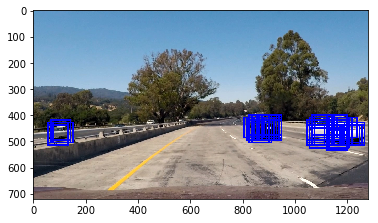

In [111]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

spatial_size=(32, 32)

img = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).ravel()
            # print('hog_features size', len(hog_features))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size).ravel()
            hist_features = color_hist(subimg, nbins=hist_bins).ravel()
            # Scale features and make a prediction
            feature_vec = np.concatenate((spatial_features, hist_features,hog_features)).ravel()
            test_features = X_scaler.transform(feature_vec.reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox_list
    
ystart = 400
ystop = 656
scale = 1.2
    
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

## Heatmap

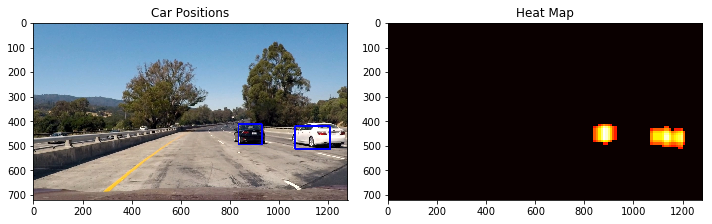

2 cars found


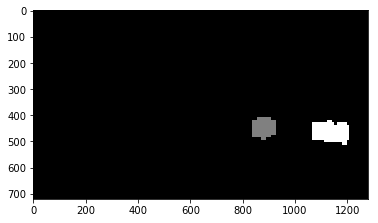

In [112]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = bbox_list # pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = img
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 8)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()
